In [40]:
import random
import os
import pickle


import pandas as pd
from pandas import read_csv

from sklearn.neural_network import MLPClassifier
from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV

import umap
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
# plt.ioff()
%matplotlib inline

import numpy as np

import wandb
# wandb.init(project="smart_attacker_same_lightbulb", entity="unr-mpl")

In [41]:
def remove_class(class_name, dataset):
    dataset = dataset[dataset["class"] != class_name]
    return dataset

In [56]:
print(f"*** Begin Processing Dataset ***")

name_of_current_data = "same_plug_uncleaned"

csv_name = f"/home/nthom/Documents/hashdata/new_data/{name_of_current_data}/combined.csv"

dataset = read_csv(csv_name)

print(f"*** Parameters in {csv_name}: {dataset.shape[0]} ***")

print(f"*** Total samples in {csv_name}: {len(dataset.index)} ***")
for device_name in dataset["class"].unique():
    num_samples = len((dataset[dataset["class"] == device_name]).index)
    print(f"*** Samples for device: {device_name} in {csv_name}: {num_samples} ({num_samples/dataset.shape[0]}%) ***")

# classes_to_remove = ["light-4", "light-5", "light-6", "light-7", "light-8",]
# for item in classes_to_remove:
#     dataset = remove_class(item, dataset)
#     dataset.dropna(inplace=True)

# Uncomment this line to take only a portion of the data
# dataset = dataset.head(len(dataset.index)//10)

# x is the entire dataframe except for the class column
x = dataset.drop(['class'], axis=1)

# y_original is an unaltered list of all values in the class column
y_original = dataset['class'].values.tolist()

# y is a dataframe of only the class column and the values have been converted to numeric representation
y = dataset['class']
counter = 0
y_temp = dataset['class'].tolist()
for unique_value in sorted(y.unique()):
    for index, value in enumerate(y):
        if value == unique_value:
            y_temp[index] = counter
    counter += 1
dataset["class"] = y_temp
y = dataset['class']
labels_numeric = dataset['class'].unique()

x_train, x_test, y_train, y_test = train_test_split(x.values, y.values, test_size=.2, stratify=y.values)

print("*** Dataset Loaded ***")

*** Begin Processing Dataset ***
*** Parameters in /home/nthom/Documents/hashdata/new_data/same_plug_uncleaned/combined.csv: 198203 ***
*** Total samples in /home/nthom/Documents/hashdata/new_data/same_plug_uncleaned/combined.csv: 198203 ***
*** Samples for device: plug-2 in /home/nthom/Documents/hashdata/new_data/same_plug_uncleaned/combined.csv: 20371 (0.10277846450356452%) ***
*** Samples for device: plug-7 in /home/nthom/Documents/hashdata/new_data/same_plug_uncleaned/combined.csv: 22010 (0.11104776416098647%) ***
*** Samples for device: plug-8 in /home/nthom/Documents/hashdata/new_data/same_plug_uncleaned/combined.csv: 19612 (0.09894905727965772%) ***
*** Samples for device: plug-3 in /home/nthom/Documents/hashdata/new_data/same_plug_uncleaned/combined.csv: 20604 (0.10395402693198387%) ***
*** Samples for device: plug-1 in /home/nthom/Documents/hashdata/new_data/same_plug_uncleaned/combined.csv: 48409 (0.24423949183412966%) ***
*** Samples for device: plug-4 in /home/nthom/Documen

In [57]:
def draw_umap(data, n_neighbors, min_dist, n_components, metric, title):
    umap_reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )

    umap_embedding = umap_reducer.fit_transform(data)

    fig = plt.figure(figsize=(5, 5))
    if n_components == 1:
        umap_df = pd.DataFrame(umap_embedding, columns=["dim1"])
        umap_df["class"] = y_train

        ax = fig.add_subplot(111)
        ax.scatter(umap_df["dim1"].values, range(len(umap_df.index)), c=umap_df["class"].values, s=1)
    elif n_components == 2:
        umap_df = pd.DataFrame(umap_embedding, columns=["dim1", "dim2"])
        umap_df["class"] = y_train

        ax = fig.add_subplot(111)
        ax.scatter(umap_df["dim1"].values, umap_df["dim2"].values, c=umap_df["class"].values, s=1)
    else:
        umap_df = pd.DataFrame(umap_embedding, columns=["dim1", "dim2", "dim3"])
        umap_df["class"] = y_train
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(umap_df["dim1"].values, umap_df["dim2"].values,umap_df["dim3"].values, c=umap_df["class"].values, s=1)

    plt.title(title, fontsize=8)

    plt.savefig(f"{name_of_current_data}.png", dpi=1200)

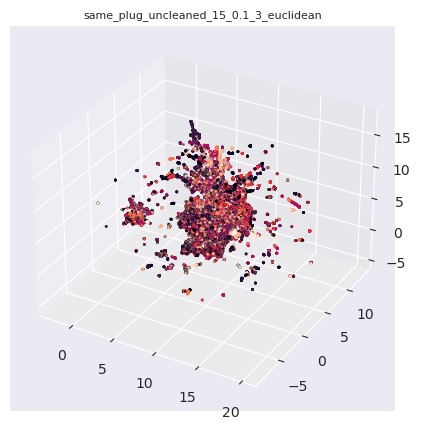

In [58]:
# n_neighbors adjusts the UMAP's attention to local structure vs. global relationships
# min_dist adjusts how close umap is allowed to place points together
n_neighbors = 15
min_dist = 0.1
n_components = 3
metric = "euclidean"
# metric = "minkowski"

draw_umap(x_train, n_neighbors, min_dist, n_components, metric, f"{name_of_current_data}_{n_neighbors}_{min_dist}_{n_components}_{metric}")

In [ ]:
# param_grid = {"learning_rate": [.1, .2, .3, .4, .5, .6 , .7, .8, .9, 1], "min_samples_leaf": [5, 10, 20, 50, 100], "l2_regularization": [.1, .3, .5, .7, 1], "max_depth": [5, 10, 30, 50, 100]}
# HGBC = ensemble.HistGradientBoostingClassifier()
#
# clf = GridSearchCV(HGBC, param_grid, n_jobs=20).fit(x.values, y.values)

In [ ]:
# Spot Check Algorithms
# x = [1000 for i in range(100)]
# x = (* x,)

models = []
# models.append((1, ensemble.BaggingClassifier(base_estimator=ensemble.RandomForestClassifier(max_depth=10), n_estimators=50, bootstrap_features=True, n_jobs=16)))
# models.append((1, ensemble.AdaBoostClassifier(base_estimator=ensemble.RandomForestClassifier(), n_estimators=50)))
# models.append((2, ensemble.AdaBoostClassifier(base_estimator=ensemble.RandomForestClassifier(max_depth=10), n_estimators=50)))
models.append((3, ensemble.AdaBoostClassifier(base_estimator=ensemble.HistGradientBoostingClassifier(), n_estimators=50)))
# models.append((4, ensemble.AdaBoostClassifier(base_estimator=ensemble.HistGradientBoostingClassifier(max_depth=1), n_estimators=32)))
# models.append((4, ensemble.AdaBoostClassifier(base_estimator=ensemble.HistGradientBoostingClassifier(max_depth=1), n_estimators=500)))
# models.append((5, ensemble.AdaBoostClassifier(base_estimator=ensemble.HistGradientBoostingClassifier(max_depth=1), n_estimators=1000)))
# models.append((6, ensemble.AdaBoostClassifier(base_estimator=ensemble.HistGradientBoostingClassifier(max_depth=1), n_estimators=10000)))
# models.append((4, ensemble.AdaBoostClassifier(base_estimator=ensemble.HistGradientBoostingClassifier(l2_regularization=0.2, learning_rate=0.2, min_samples_leaf=100), n_estimators=50)))
# models.append((1, ensemble.GradientBoostingClassifier(max_depth=10)))
# models.append((1, ensemble.GradientBoostingClassifier(max_depth=100)))

# evaluate each model
for model_name, model in models:
    print(f"*** Begin Training {model_name} ***")

    print(y_train.shape)
    model.fit(x_train, y_train)
    print(f"*** {model_name} Trained ***")

    y_pred = model.predict(x_test)
    y_probas = model.predict_proba(x_test)

    total_accuracy = accuracy_score(y_test, y_pred)
    total_precision = precision_score(y_test, y_pred, average='weighted')
    total_recall = recall_score(y_test, y_pred, average='weighted')
    total_f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {total_accuracy}")
    print(f"Precision: {total_precision}")
    print(f"Recall: {total_recall}")
    print(f"F1: {total_f1}")

    # wandb.log({f"Total accuracy TSR on {name_of_current_data}": total_accuracy,
    #            "Dataset": name_of_current_data,
    #            "Num Samples": dataset.shape[0]})
    # wandb.log({f"Total precision TSR on {name_of_current_data}": total_precision,
    #            "Dataset": name_of_current_data,
    #            "Num Samples": dataset.shape[0]})
    # wandb.log({f"Total recall TSR on {name_of_current_data}": total_recall,
    #            "Dataset": name_of_current_data,
    #            "Num Samples": dataset.shape[0]})
    # wandb.log({f"Total f1 TSR on {name_of_current_data}": total_f1,
    #            "Dataset": name_of_current_data,
    #            "Num Samples": dataset.shape[0]})


*** Begin Training 3 ***
(158562,)
